In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
import gc
import torch
import torch.nn as nn
from transformer_lens import HookedTransformer
from transformer_lens import utils as tl_utils
from transformers import AutoModelForCausalLM, AutoTokenizer
import einops
from jaxtyping import Int, Float
from torch import Tensor
from matplotlib import pyplot as plt
import numpy as np
import functools
from typing import Dict, Optional, Tuple, Union
from jaxtyping import Float, Int
from transformer_lens.HookedTransformerConfig import HookedTransformerConfig
from transformer_lens.hook_points import HookedRootModule, HookPoint
from copy import deepcopy

In [2]:
device_ids = [0, 1]
devices = [torch.device(f"cuda:{i}") for i in device_ids]
torch.cuda.empty_cache()
for device in devices:
    print(torch.cuda.memory_summary(device=device))

KeyError: 'allocated_bytes.all.current'

In [51]:
with torch.no_grad():
    tokens = tl_model.tokenizer.encode("Hello |:", return_tensors="pt")
    print(tokens.data)

tensor([[    1, 15043,   891, 29901]])


In [37]:
def check_similarity_with_hf_model(
    tl_model: HookedTransformer,
    hf_model: AutoModelForCausalLM,
    atol: float,
    prompt="Hello world!",
):
    tokens = tl_model.tokenizer.encode(prompt, return_tensors="pt")
    hf_logits = hf_model(tokens.to(devices[0])).logits
    tl_logits = tl_model(tokens.to(devices[1]), prepend_bos=False)
    assert torch.allclose(tl_logits.cpu(), hf_logits.cpu(), atol=atol), "Numerical error too large"

In [3]:
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

hf_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float32,
).to(devices[0])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    hf_model=AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        low_cpu_mem_usage=True,
        torch_dtype=torch.float32,
    ),
    tokenizer=AutoTokenizer.from_pretrained(MODEL_NAME),
    device=devices[1],
    n_devices=1,
    move_to_device=True,
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    center_unembed=False,
    torch_dtype=torch.float32,
    
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [6]:
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=1)

AssertionError: 

In [92]:
# before running this we've replaced ln1 and ln2 at each layer with the corresponding ln in the HF model
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=0.0001)

In [11]:
class AttnWrapper(torch.nn.Module):
    def __init__(self, attn):
        super().__init__()
        self.attn = attn
        self.save_activations = False 
        self.activations = None

    def forward(self, *args, **kwargs):
        output = self.attn(*args, **kwargs)
        if self.save_activations:
            self.activations = output[0]
        return output

class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm

        self.block.self_attn = AttnWrapper(self.block.self_attn)
        self.post_attention_layernorm = self.block.post_attention_layernorm

        self.attn_out_unembedded = None
        self.intermediate_resid_unembedded = None
        self.mlp_out_unembedded = None
        self.block_out_unembedded = None

        self.activations = None

        self.save_activations = False
        self.save_internal_decodings = False


    def forward(self, *args, **kwargs):
        output = self.block(*args, **kwargs)
        activations: Float[Tensor, "batch_size seq_len d_model"] = output[0]

        if self.save_activations:
            self.activations = activations

        return output

    def reset(self):
        self.activations = None
        self.block.self_attn.activations = None


class Llama2Wrapper:
    def __init__(self, hf_model):
        self.wrapped_model = hf_model

        for i, layer in enumerate(self.wrapped_model.model.layers):
            self.wrapped_model.model.layers[i] = BlockOutputWrapper(
                layer, self.wrapped_model.lm_head, self.wrapped_model.model.norm
            )

    def set_save_activations(self, value, layers=None):
        if layers is None:
            for layer in self.wrapped_model.model.layers:
                layer.save_activations = value
                layer.block.self_attn.save_activations = value
        elif isinstance(layers, int):
            self.wrapped_model.model.layers[layers].save_activations = value
            self.wrapped_model.model.layers[layers].block.self_attn.save_activations = value
        elif isinstance(layers[0], int):
            for layer in layers:
                self.wrapped_model.model.layers[layer].save_activations = value
                self.wrapped_model.model.layers[layer].block.self_attn.save_activations = value
        else:
            assert False, "Incorrect input arguments to set_save_activations function"

    def set_save_internal_decodings(self, value):
        for layer in self.wrapped_model.model.layers:
            layer.save_internal_decodings = value

    def get_logits(self, tokens):
        with torch.no_grad():
            logits = self.wrapped_model(tokens).logits
            return logits

    def get_last_activations(self, layer):
        return self.wrapped_model.model.layers[layer].activations

    def reset_all(self):
        for layer in self.wrapped_model.model.layers:
            layer.reset()

    def __call__(self, *args, **kwargs):
        return self.wrapped_model(*args, **kwargs)

    def unwrap(self):
        for i, layer in enumerate(self.wrapped_model.model.layers):
            self.wrapped_model.model.layers[i] = layer.block


In [12]:
hf_wrapped_model = Llama2Wrapper(hf_model)

In [52]:
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_wrapped_model, atol=1)

AssertionError: 

In [15]:
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_wrapped_model, atol=1.4)

Check the error at different layers

In [14]:
def check_error_layer(layer):
    hf_wrapped_model.reset_all()
    hf_wrapped_model.set_save_activations(True, layer)
    hf_wrapped_model.set_save_internal_decodings(True)

    tokens = tl_model.tokenizer.encode("Hello world!", return_tensors="pt")
    with torch.no_grad():
        hf_logits = hf_wrapped_model.get_logits(tokens.to(devices[0]))
        hf_activations = hf_wrapped_model.get_last_activations(layer)
        print("HF activations", hf_activations[0, 0, :10])

    tl_activations = torch.zeros_like(hf_activations, device=devices[1])

    def hook_fn(activations, hook):
        tl_activations = activations
        print("TL activations", activations[0, 0, :10])
    
    hook_filter = lambda name: name.startswith(f"blocks.{layer}.hook_resid_post")
    
    with torch.no_grad():
        tl_model.run_with_hooks(
            tokens.to(devices[1]),
            prepend_bos=False,
            fwd_hooks=[(hook_filter, hook_fn)],
        )

    diff = torch.abs(tl_activations.cpu() - hf_activations.cpu())
    print("Diff", diff[0, 0, :10])
    print("Max difference", diff.max().item())
    print("Max difference in last token position", diff[0,-1,:].max().item())
    print("Mean difference in the last token position", diff[-1,-1,:].mean().item())
    print("Mean difference in first token position", diff[-1,0,:].mean().item())

    hf_wrapped_model.set_save_activations(False)
    hf_wrapped_model.set_save_internal_decodings(False)
    hf_wrapped_model.reset_all()

In [13]:
check_error_layer(0)

NameError: name 'check_error_layer' is not defined

### Observations:

- The TL model seems to consume about 0.5 GB more of GPU memory
```
 Device 1 [NVIDIA RTX A6000] PCIe GEN 1@16x RX: 0.000 KiB/s TX: 0.977 MiB/s
 GPU 210MHz  MEM 405MHz  TEMP  42°C FAN  30% POW  26 / 300 W
 GPU[                              0%] MEM[||||||||||||||25.965Gi/47.988Gi]
 Device 2 [NVIDIA RTX A6000] PCIe GEN 1@16x RX: 1.953 MiB/s TX: 0.000 KiB/s
 GPU 210MHz  MEM 405MHz  TEMP  42°C FAN  30% POW  22 / 300 W
 GPU[                              1%] MEM[||||||||||||||26.472Gi/47.988Gi]
```
- Assert triggered with atol=1.0 but not with atol=1.4
- Extremely big imprecision at hook_resid_post even at early layers
    - Max difference `activations_layer_2[0,0,:].max() = 758.8073120117188`
    - Max difference in `activations_layer_2[0,-1,:].max() = 0.8543080687522888`
    - Mean difference in `activations_layer_2[0,-1,:].max() = 0.8543080687522888`
    - Mean difference `activations_layer_2[0,-1,:].mean() = 0.03889806941151619`
    - Mean difference `activations_layer_2[0,0,:].mean() = 0.6288346648216248`
- Even at layer 0?!?
    - Max difference 4.763709545135498
    - Max difference in last token position 1.8098640441894531
    - Mean difference in the last token position 0.02045099064707756
    - Mean difference in first token position 0.06380023807287216

Let's check the earliest part where the differences occur

In [15]:
class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm

        self.block.self_attn = AttnWrapper(self.block.self_attn)
        self.post_attention_layernorm = self.block.post_attention_layernorm

        self.attn_out_unembedded = None
        self.intermediate_resid_unembedded = None
        self.mlp_out_unembedded = None
        self.block_out_unembedded = None

        self.activations = None

        self.save_activations = False
        self.save_internal_decodings = False

    def forward(self, *args, **kwargs):
        # print(kwargs.keys())
        # print(args[0].shape)
        if self.save_activations:
            self.activations = args[0]
        output = self.block(*args, **kwargs)
        activations: Float[Tensor, "batch_size seq_len d_model"] = output[0]
        # if self.save_activations:
        #     self.activations = activations
        return output

    def reset(self):
        self.activations = None
        self.block.self_attn.activations = None

In [10]:
#hf_wrapped_model.unwrap()
hf_wrapped_model = Llama2Wrapper(hf_model)

NameError: name 'Llama2Wrapper' is not defined

In [14]:
def check_error_layer_resid_pre(layer, atol=1.0):
    hf_wrapped_model.reset_all()
    hf_wrapped_model.set_save_activations(True, layer)
    hf_wrapped_model.set_save_internal_decodings(True)

    tokens = tl_model.tokenizer.encode("Hello world!", return_tensors="pt")
    with torch.no_grad():
        hf_logits = hf_wrapped_model.get_logits(tokens.to(devices[0]))
        hf_activations = hf_wrapped_model.get_last_activations(layer)
        # print("HF activations", hf_activations[0, 0, :10])

    tl_activations_ = torch.zeros_like(hf_activations, device="cpu")

    def hook_fn(activations, hook):
        tl_activations_ = activations.clone().cpu()
        # print("TL activations", activations[0, 0, :10])
    
    hook_filter = lambda name: name.startswith(f"blocks.{layer}.hook_resid_pre")
    
    with torch.no_grad():
        tl_model.run_with_hooks(
            tokens.to(devices[1]),
            prepend_bos=False,
            fwd_hooks=[(hook_filter, hook_fn)],
        )

    diff_ = torch.abs(tl_activations_ - hf_activations.cpu())

    mean_diff = diff_.mean().item()
    std_diff = diff_.std().item()
    max_diff = diff_.max().item()

    print(f"Mean diff: {mean_diff:.3f}, std diff: {std_diff:.3f}, max diff: {max_diff:.3f}")

    # print("Diff", diff_[0,0,:10])
    # print("Initial mean difference", diff_[0,0,:10].mean().item())
    # print("Max difference", diff_.max().item())
    # print("Max difference in last token position", diff_[0,-1,:].max().item())
    # print("Mean difference in the last token position", diff_[-1,-1,:].mean().item())
    # print("Mean difference in first token position", diff_[-1,0,:].mean().item())

    hf_wrapped_model.set_save_activations(False)
    hf_wrapped_model.set_save_internal_decodings(False)
    hf_wrapped_model.reset_all()

    return mean_diff, std_diff, max_diff

    # assert torch.allclose(tl_activations_.cpu(), hf_activations.cpu(), atol=atol)

In [16]:
mean_diffs = []
std_diffs = []
max_diffs = []

for i in range(32):
    mean_diff, std_diff, max_diff = check_error_layer_resid_pre(i, atol=1.0)
    mean_diffs.append(mean_diff)
    std_diffs.append(std_diff)
    max_diffs.append(max_diff)

# plot the results using matplotlib in the same figure with legends


Mean diff: 0.032, std diff: 0.068, max diff: 4.764
Mean diff: 0.182, std diff: 6.896, max diff: 754.642
Mean diff: 0.189, std diff: 6.934, max diff: 758.807
Mean diff: 0.202, std diff: 6.935, max diff: 758.917
Mean diff: 0.234, std diff: 7.001, max diff: 766.477
Mean diff: 0.246, std diff: 7.002, max diff: 766.606
Mean diff: 0.260, std diff: 7.002, max diff: 766.675
Mean diff: 0.275, std diff: 7.002, max diff: 766.750
Mean diff: 0.292, std diff: 7.002, max diff: 766.798
Mean diff: 0.307, std diff: 7.003, max diff: 767.036
Mean diff: 0.323, std diff: 7.003, max diff: 767.103
Mean diff: 0.333, std diff: 7.004, max diff: 767.378
Mean diff: 0.348, std diff: 7.006, max diff: 767.737
Mean diff: 0.364, std diff: 7.009, max diff: 768.382
Mean diff: 0.392, std diff: 7.010, max diff: 768.585
Mean diff: 0.435, std diff: 7.012, max diff: 768.893
Mean diff: 0.446, std diff: 7.037, max diff: 772.978
Mean diff: 0.474, std diff: 7.040, max diff: 773.291
Mean diff: 0.507, std diff: 7.042, max diff: 773

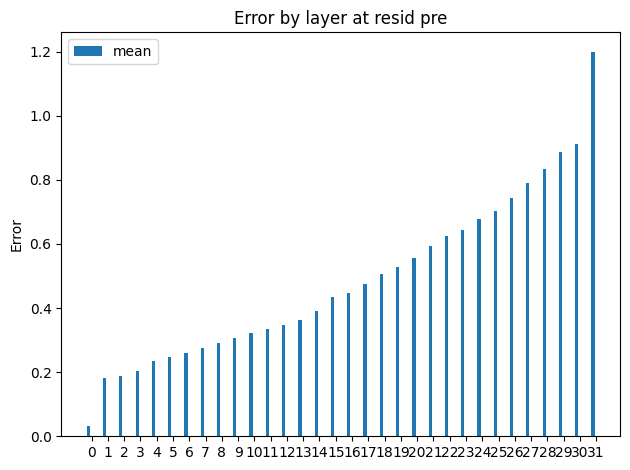

In [17]:
x = np.arange(32)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, mean_diffs, width, label='mean')
#rects2 = ax.bar(x, std_diffs, width, label='std')
#rects3 = ax.bar(x + width, max_diffs, width, label='max')

ax.set_ylabel('Error')
ax.set_title('Error by layer at resid pre')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

plt.show()

In [73]:
check_error_layer_resid_pre(0, atol=0.2)

HF activations tensor([ 1.8387e-03, -3.8147e-03,  9.6130e-04,  2.9297e-03, -3.9978e-03,
        -8.0566e-03, -5.4016e-03, -2.9449e-03, -6.7444e-03, -3.8147e-06],
       device='cuda:0')
TL activations tensor([ 1.8387e-03, -3.8147e-03,  9.6130e-04,  2.9297e-03, -3.9978e-03,
        -8.0566e-03, -5.4016e-03, -2.9449e-03, -6.7444e-03, -3.8147e-06],
       device='cuda:1')
Diff tensor([1.8387e-03, 3.8147e-03, 9.6130e-04, 2.9297e-03, 3.9978e-03, 8.0566e-03,
        5.4016e-03, 2.9449e-03, 6.7444e-03, 3.8147e-06])
Initial mean difference 0.003669357392936945
Max difference 0.1337890625
Max difference in last token position 0.10546875
Mean difference in the last token position 0.007406735792756081
Mean difference in first token position 0.00494754733517766


In [75]:
check_error_layer_resid_pre(30, atol=0.2)

HF activations tensor([ 0.0886, -0.5498,  0.3824, -0.1176, -0.3164,  0.5601,  0.5420,  0.2211,
        -0.3377,  0.0552], device='cuda:0')
TL activations tensor([ 0.0810, -0.5411,  0.3784, -0.1277, -0.3329,  0.5589,  0.5300,  0.2359,
        -0.3244,  0.0455], device='cuda:1')
Diff tensor([0.0886, 0.5498, 0.3824, 0.1176, 0.3164, 0.5601, 0.5420, 0.2211, 0.3377,
        0.0552])
Initial mean difference 0.31708166003227234
Max difference 770.1580810546875
Max difference in last token position 49.95972442626953
Mean difference in the last token position 0.925025224685669
Mean difference in first token position 0.6924221515655518


AssertionError: 

In [18]:
def check_relative_error_layer_resid_pre(layer, atol=1.0):
    hf_wrapped_model.reset_all()
    hf_wrapped_model.set_save_activations(True, layer)
    hf_wrapped_model.set_save_internal_decodings(True)

    tokens = tl_model.tokenizer.encode("Hello world! How are you?", return_tensors="pt").cpu()

    hf_activations = torch.zeros((len(tokens), len(tokens[0]), 4096), device="cpu", dtype=torch.float32)
    tl_activations = torch.zeros_like(hf_activations, device="cpu", dtype=torch.float32)

    with torch.no_grad():
        hf_logits = hf_wrapped_model.get_logits(tokens.to(devices[0]))
        hf_activations = hf_wrapped_model.get_last_activations(layer).cpu()
        print("HF activations", hf_activations[0, 0, :5])

    def store_activations(activations, hook, tl_activations_):
        tl_activations_ += activations.cpu()
        print("TL activations", tl_activations_[0, 0, :5])
    
    hook_filter = lambda name: name.startswith(f"blocks.{layer}.hook_resid_pre")
    hook_fn = functools.partial(store_activations, tl_activations_=tl_activations)
    
    with torch.no_grad():
        tl_model.run_with_hooks(
            tokens.to(devices[1]),
            prepend_bos=False,
            fwd_hooks=[(hook_filter, hook_fn)],
        )

        
    diff = torch.abs((hf_activations - tl_activations) / hf_activations)
    print("Diff", diff[0, 0, :5])

    mean_diff = diff.mean().item()
    std_diff = diff.std().item()
    max_diff = diff.max().item()

    print(f"Layer {layer}, mean error: {mean_diff:.3f}, std diff: {std_diff:.3f}, max diff: {max_diff:.3f}")

    # print("Diff", diff_[0,0,:10])
    # print("Initial mean difference", diff_[0,0,:10].mean().item())
    # print("Max difference", diff_.max().item())
    # print("Max difference in last token position", diff_[0,-1,:].max().item())
    # print("Mean difference in the last token position", diff_[-1,-1,:].mean().item())
    # print("Mean difference in first token position", diff_[-1,0,:].mean().item())

    hf_wrapped_model.set_save_activations(False)
    hf_wrapped_model.set_save_internal_decodings(False)
    hf_wrapped_model.reset_all()

    return mean_diff, std_diff, max_diff

    # assert torch.allclose(tl_activations_.cpu(), hf_activations.cpu(), atol=atol)

In [19]:
mean_diffs = []
std_diffs = []
max_diffs = []

for i in range(32):
    mean_diff, std_diff, max_diff = check_relative_error_layer_resid_pre(i, atol=1.0)
    mean_diffs.append(mean_diff)
    std_diffs.append(std_diff)
    max_diffs.append(max_diff)

# plot the results using matplotlib in the same figure with legends

HF activations tensor([-0.0116,  0.0113,  0.0560,  0.0331, -0.1477])
TL activations tensor([ 0.0018, -0.0038,  0.0010,  0.0029, -0.0040])
Diff tensor([1.1582, 1.3382, 0.9828, 0.9115, 0.9729])
Layer 0, mean error: 2.635, std diff: 87.518, max diff: 12687.897
HF activations tensor([ 0.0699, -0.5114,  0.0642, -0.0617, -0.0583])
TL activations tensor([-0.0130,  0.0088,  0.0571,  0.0356, -0.1513])
Diff tensor([1.1862, 1.0171, 0.1104, 1.5774, 1.5940])
Layer 1, mean error: 5.837, std diff: 520.253, max diff: 93607.367
HF activations tensor([ 0.1070, -0.5451,  0.0946, -0.1130, -0.0241])
TL activations tensor([ 0.0669, -0.5043,  0.0658, -0.0571, -0.0646])
Diff tensor([0.3745, 0.0748, 0.3042, 0.4951, 1.6782])
Layer 2, mean error: 3.360, std diff: 133.236, max diff: 22969.088
HF activations tensor([ 0.1178, -0.5735,  0.1002, -0.1144, -0.0045])
TL activations tensor([ 0.1041, -0.5380,  0.0961, -0.1084, -0.0304])
Diff tensor([0.1162, 0.0620, 0.0404, 0.0526, 5.7385])
Layer 3, mean error: 2.537, std 

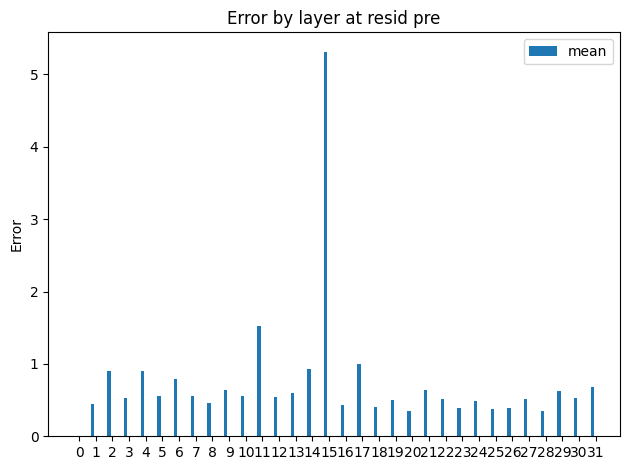

In [70]:
x = np.arange(32)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, mean_diffs, width, label='mean')
#rects2 = ax.bar(x, std_diffs, width, label='std')
#rects3 = ax.bar(x + width, max_diffs, width, label='max')

ax.set_ylabel('Error')
ax.set_title('Error by layer at resid pre')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

plt.show()

abs((hf_acts - tl_acts) / hf_acts)

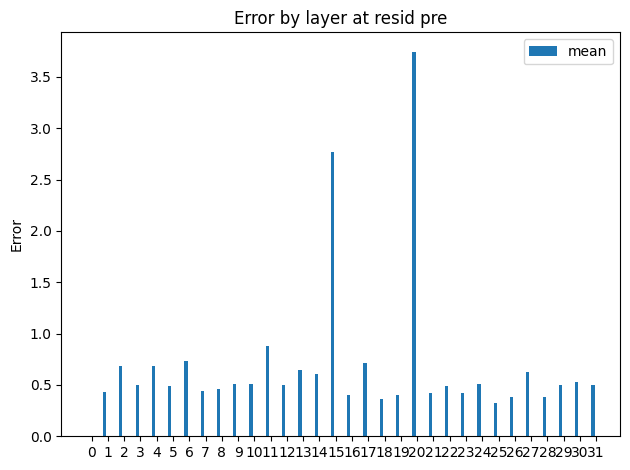

In [75]:
x = np.arange(32)
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, mean_diffs, width, label='mean')
#rects2 = ax.bar(x, std_diffs, width, label='std')
#rects3 = ax.bar(x + width, max_diffs, width, label='max')

ax.set_ylabel('Error')
ax.set_title('Error by layer at resid pre')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

plt.show()

Is the layernorm at fault?

In [41]:
class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm

        self.block.self_attn = AttnWrapper(self.block.self_attn)
        # self.input_layernorm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.input_layernorm = self.block.input_layernorm
        self.post_attention_layernorm = self.block.post_attention_layernorm

        self.attn_out_unembedded = None
        self.intermediate_resid_unembedded = None
        self.mlp_out_unembedded = None
        self.block_out_unembedded = None

        self.activations = None

        self.save_activations = False
        self.save_internal_decodings = False

    def forward(self, *args, **kwargs):
        # print(kwargs.keys())
        # print(args[0].shape)
        if self.save_activations:
            print("HF Pre activations", args[0][0,0,:10])
            self.activations = self.input_layernorm(args[0])
        output = self.block(*args, **kwargs)
        # activations: Float[Tensor, "batch_size seq_len d_model"] = output[0]
        # if self.save_activations:
        #     self.activations = activations
        return output

    def reset(self):
        self.activations = None
        self.block.self_attn.activations = None 

hf_wrapped_model.unwrap()
hf_wrapped_model = Llama2Wrapper(hf_model)

In [8]:
ln1 = tl_model.blocks[0].ln1

In [46]:
def check_relative_error_layer_pre_attn(layer, atol=1.0):
    hf_wrapped_model.reset_all()
    hf_wrapped_model.set_save_activations(True, layer)
    hf_wrapped_model.set_save_internal_decodings(True)

    tokens = tl_model.tokenizer.encode("Hello world! How are you?", return_tensors="pt").cpu()

    hf_activations = torch.zeros((len(tokens), len(tokens[0]), 4096), device="cpu", dtype=torch.float32)
    tl_activations = torch.zeros_like(hf_activations, device="cpu", dtype=torch.float32)

    with torch.no_grad():
        hf_logits = hf_wrapped_model.get_logits(tokens.to(devices[0]))
        hf_activations = hf_wrapped_model.get_last_activations(layer).cpu()
        print("HF activations", hf_activations[0, 0, :5])

    def store_activations(activations, hook, tl_activations_):
        print(activations[0, 0, 0, :5])
        tl_activations_ += ln1(activations[:,:,0,:]).cpu()
        print("TL activations", tl_activations_[0, 0, :5])
    
    # hook_filter = lambda name: name.startswith(f"blocks.{layer}.hook_q_input")
    # tl_utils.get_act_name(layer, "hook_q_input")
    # hook_name = tl_utils.get_act_name("q_input", layer),
    # print(hook_name)
    hook_filter = lambda name: name.startswith(f"blocks.{layer}.hook_attn_in")
    hook_fn = functools.partial(store_activations, tl_activations_=tl_activations)
    
    with torch.no_grad():
        tl_model.run_with_hooks(
            tokens.to(devices[1]),
            prepend_bos=False,
            fwd_hooks=[(hook_filter, hook_fn)],
        )
        
    diff = torch.abs((hf_activations - tl_activations) / hf_activations)
    print("Diff", diff[0, 0, :5])

    mean_diff = diff.mean().item()
    std_diff = diff.std().item()
    max_diff = diff.max().item()

    print(f"Layer {layer}, mean error: {mean_diff:.3f}, std diff: {std_diff:.3f}, max diff: {max_diff:.3f}")

    hf_wrapped_model.set_save_activations(False)
    hf_wrapped_model.set_save_internal_decodings(False)
    hf_wrapped_model.reset_all()

    return mean_diff, std_diff, max_diff

    # assert torch.allclose(tl_activations_.cpu(), hf_activations.cpu(), atol=atol)

In [18]:
# tl_model.set_use_hook_mlp_in(True)
# tl_model.set_use_split_qkv_input(True)
# tl_model.set_use_attn_result(True)

In [28]:
tl_model.set_use_attn_in(True)

In [47]:
check_relative_error_layer_pre_attn(0, atol=1.0)

HF Pre activations tensor([ 1.8387e-03, -3.8147e-03,  9.6130e-04,  2.9297e-03, -3.9978e-03,
        -8.0566e-03, -5.4016e-03, -2.9449e-03, -6.7444e-03, -3.8147e-06],
       device='cuda:0')
HF activations tensor([ 0.0065, -0.0064,  0.0004,  0.0046, -0.0072])
tensor([ 0.0018, -0.0038,  0.0010,  0.0029, -0.0040], device='cuda:1')
TL activations tensor([ 0.0070, -0.0068,  0.0004,  0.0049, -0.0077])
Diff tensor([0.0710, 0.0710, 0.0710, 0.0710, 0.0710])
Layer 0, mean error: 0.037, std diff: 0.016, max diff: 0.071


(0.036657512187957764, 0.01582922227680683, 0.071043960750103)

In [ ]:
tokens = tl_model.tokenizer.encode("Hello world! How are you?", return_tensors="pt").cpu()
hook_filter = utils.get_act_name


with torch.no_grad():
    tl_model.run_with_hooks(
        tokens.to(devices[1]),
        prepend_bos=False,
    )

### Replacing TL LN with HF LN at *every* layer

In [16]:
from copy import deepcopy

In [83]:
for layer in range(32):
    tl_model.blocks[layer].ln1 = deepcopy(hf_wrapped_model.wrapped_model.model.layers[layer].block.input_layernorm).to(devices[1])
    tl_model.blocks[layer].ln2 = deepcopy(hf_wrapped_model.wrapped_model.model.layers[layer].block.post_attention_layernorm).to(devices[1])

In [75]:
class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm

        self.block.self_attn = AttnWrapper(self.block.self_attn)
        # self.input_layernorm = LlamaRMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.input_layernorm = self.block.input_layernorm
        self.post_attention_layernorm = self.block.post_attention_layernorm

        self.attn_out_unembedded = None
        self.intermediate_resid_unembedded = None
        self.mlp_out_unembedded = None
        self.block_out_unembedded = None

        self.activations = None

        self.save_activations = False
        self.save_internal_decodings = False

    def forward(self, *args, **kwargs):
        # print(kwargs.keys())
        # print(args[0].shape)
        # if self.save_activations:
        #     print("HF Pre activations", args[0][0,0,:10])
        #     self.activations = self.input_layernorm(args[0])
        output = self.block(*args, **kwargs)
        # activations: Float[Tensor, "batch_size seq_len d_model"] = output[0]
        # if self.save_activations:
        #     self.activations = activations
        return output

    def reset(self):
        self.activations = None
        self.block.self_attn.activations = None 

# hf_wrapped_model.unwrap()
hf_wrapped_model = Llama2Wrapper(hf_model)

In [66]:
for layer in range(32):
    hf_wrapped_model.wrapped_model.model.layers[layer].input_layernorm.to(devices[0])
    post_attention_layernorm

resid_pre_hook -> attn_in_hook -> ? -> attn_out

In [85]:
def replace_tl_rms(layer, disable_hooks=False, atol=1.0):
    tokens = tl_model.tokenizer.encode("Hello world! How are you?", return_tensors="pt").cpu()

    tl_activations = torch.zeros((len(tokens), len(tokens[0]), 4096), device=devices[1], dtype=torch.float32)

    with torch.no_grad():
        hf_logits = hf_wrapped_model(tokens.to(devices[0])).logits

    def calculate_attn(attn_in, hook, tl_activations_):
        layer = hook.layer()
        assert hook.name.endswith("hook_attn_in"), "Invalid attn hook"
        hf_ln = hf_wrapped_model.wrapped_model.model.layers[layer].input_layernorm.to(devices[1])
        attn_out = tl_model.blocks[layer].attn(
            query_input=hf_ln(attn_in),
            key_input=hf_ln(attn_in),
            value_input=hf_ln(attn_in),
            past_kv_cache_entry=None,
            attention_mask=None
        )
        hf_ln = hf_wrapped_model.wrapped_model.model.layers[layer].input_layernorm.to(devices[0])
        if layer == 0:
            print(attn_out.shape)
        tl_activations_ += attn_out - tl_activations_

    # elif hook.name.endswith("hook_mlp_in"):
    #     hf_ln = hf_wrapped_model.wrapped_model.model.layers[layer].post_attention_layernorm
    #     tl_activations_ += hf_ln(activations) - tl_activations_

    #     print(activations[0, 0, 0, :5])
    #     tl_activations_ += ln1(activations[:,:,0,:]).cpu()
    #     print("TL activations", tl_activations_[0, 0, :5])
    
    # hook_filter = lambda name: name.startswith(f"blocks.{layer}.hook_q_input")
    # tl_utils.get_act_name(layer, "hook_q_input")
    # hook_name = tl_utils.get_act_name("q_input", layer),
    # print(hook_name)

    hook_filter = lambda name: name.endswith(f"hook_attn_in")
    hook_fn = functools.partial(
        calculate_attn,
        tl_activations_=tl_activations
    )
    
    with torch.no_grad():
        tl_logits = tl_model.run_with_hooks(
            tokens.to(devices[1]),
            prepend_bos=False,
            fwd_hooks=([] if disable_hooks else [(hook_filter, hook_fn)]),
        )
        
    relative_error = torch.abs((hf_logits.cpu() - tl_logits.cpu()) / hf_logits.cpu())
    print("Relative error", relative_error[0, 0, :5])

    mean_diff = relative_error.mean().item()
    std_diff = relative_error.std().item()
    max_diff = relative_error.max().item()

    print(f"Layer {layer}, mean rel. error: {mean_diff:.3f}, std diff: {std_diff:.3f}, max diff: {max_diff:.3f}")

    return mean_diff, std_diff, max_diff

    # assert torch.allclose(tl_activations_.cpu(), hf_activations.cpu(), atol=atol)

In [77]:
# without replacement
replace_tl_rms(0, atol=1.0)

Relative error tensor([0.1777, 0.8098, 0.0275, 0.0883, 0.0229])
Layer 0, mean rel. error: 0.368, std diff: 12.150, max diff: 5055.095


(0.3679742217063904, 12.150411605834961, 5055.0947265625)

In [86]:
# without replacement
replace_tl_rms(0, disable_hooks=True, atol=1.0)

Relative error tensor([8.7756e-05, 1.5429e-03, 1.9755e-05, 1.9332e-05, 8.5034e-06])
Layer 0, mean rel. error: 0.000, std diff: 0.001, max diff: 0.225


(1.5189039913821034e-05, 0.0005916812806390226, 0.22513586282730103)

### Llama2 RMSNorm

Huggingface

In [ ]:
def hf_ln_forward(self, hidden_states):
    input_dtype = hidden_states.dtype
    hidden_states = hidden_states.to(torch.float32)
    variance = hidden_states.pow(2).mean(-1, keepdim=True)
    hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
    return self.weight * hidden_states.to(input_dtype)

TransformerLens

In [ ]:
def tl_ln_forward(
    self, x: Float[torch.Tensor, "batch pos length"]
) -> Float[torch.Tensor, "batch pos length"]:
    if self.cfg.dtype not in [torch.float32, torch.float64]:
        x = x.to(torch.float32)

    scale: Float[torch.Tensor, "batch pos 1"] = self.hook_scale(
        (x.pow(2).mean(-1, keepdim=True) + self.eps).sqrt()
    )
    x = self.hook_normalized(x * inv_scale).to(self.cfg.dtype)  # [batch, pos, length]
    return x * self.w

### Fixing the implementation

In [ ]:
# self.wrapped_model.model.layers[i] = BlockOutputWrapper(
#     layer, self.wrapped_model.lm_head, self.wrapped_model.model.norm
# )

In [10]:
class RMSNorm(nn.Module):
    def __init__(
        self, cfg: Union[Dict, HookedTransformerConfig], length: Optional[int] = None
    ):
        """
        RMSNorm - LayerNorm without the centering and bias (RMS = Root Mean Square)

        length (Optional[int]): If the dimension of the RMSNorm. If not provided, assumed to be d_model
        """
        super().__init__()
        if isinstance(cfg, Dict):
            cfg = HookedTransformerConfig.from_dict(cfg)
        self.cfg = cfg
        self.eps = self.cfg.eps
        if length is None:
            self.length = self.cfg.d_model
        else:
            self.length = length

        self.w = nn.Parameter(torch.ones(self.length, dtype=cfg.dtype))

        # Adds a hook point for the normalisation scale factor
        self.hook_scale = HookPoint()  # [batch, pos, 1]
        self.hook_normalized = HookPoint()  # [batch, pos, length]

    def forward(
        self, x: Float[torch.Tensor, "batch pos length"]
    ) -> Float[torch.Tensor, "batch pos length"]:
        if self.cfg.dtype not in [torch.float32, torch.float64]:
            x = x.to(torch.float32)

        inv_scale = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

        # scale: Float[torch.Tensor, "batch pos 1"] = self.hook_scale(
        #     (x.pow(2).mean(-1, keepdim=True) + self.eps).sqrt()
        # )
        x = self.hook_normalized(x * inv_scale).to(self.cfg.dtype)  # [batch, pos, length]
        return x * self.w

In [97]:
print(f"HF eps {tl_model.blocks[0].ln1.variance_epsilon}")
print(f"HF w {tl_model.blocks[0].ln1.weight[:5]}")

HF eps 1e-05
HF w tensor([0.0298, 0.0140, 0.0031, 0.0131, 0.0151], device='cuda:1',
       grad_fn=<SliceBackward0>)


In [11]:
print(f"TL eps {tl_model.blocks[0].ln1.eps}")
print(f"TL w {tl_model.blocks[0].ln1.w[:5]}")

TL eps 1e-06
TL w tensor([0.0298, 0.0140, 0.0031, 0.0131, 0.0151], device='cuda:1',
       grad_fn=<SliceBackward0>)


In [ ]:
for layer in range(32):
    tl_model.blocks[layer].ln1 = deepcopy(hf_wrapped_model.wrapped_model.model.layers[layer].block.input_layernorm).to(devices[1])
    tl_model.blocks[layer].ln2 = deepcopy(hf_wrapped_model.wrapped_model.model.layers[layer].block.post_attention_layernorm).to(devices[1])

In [17]:
tl_layer_norms = []
for layer in range(32):
    lns = [
        deepcopy(tl_model.blocks[layer].ln1),
        deepcopy(tl_model.blocks[layer].ln2)
    ]
    tl_layer_norms.append(lns)

In [28]:
layer_norms = []
for layer in range(32):
    ln1 = RMSNorm(tl_model.cfg, length=tl_model.cfg.d_model)
    ln2 = RMSNorm(tl_model.cfg, length=tl_model.cfg.d_model)
    ln1.w = torch.nn.Parameter(hf_model.model.layers[layer].input_layernorm.weight.clone())
    ln2.w = torch.nn.Parameter(hf_model.model.layers[layer].post_attention_layernorm.weight.clone())
    ln1.to(devices[1])
    ln2.to(devices[1])
    lns = [ln1, ln2]
    layer_norms.append(lns)

In [38]:
# before changing ANYTHING
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=1)

AssertionError: Numerical error too large

In [47]:
for layer in range(32):
    tl_model.blocks[layer].ln1 = layer_norms[layer][0].to(devices[1])
    tl_model.blocks[layer].ln2 = layer_norms[layer][1].to(devices[1])

In [48]:
# before running this we've replaced ln1 and ln2 at each layer with the corresponding ln in the HF model
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=1)

AssertionError: Numerical error too large

In [44]:
print(hf_model.model.layers[10].input_layernorm.variance_epsilon)
print(hf_model.model.layers[10].post_attention_layernorm.variance_epsilon)

1e-05
1e-05


In [46]:
print(tl_model.blocks[10].ln1.eps)
print(tl_model.blocks[10].ln2.eps)

1e-06
1e-06


In [54]:
layer_norms_new_eps = []
for layer in range(32):
    ln1 = RMSNorm(tl_model.cfg, length=tl_model.cfg.d_model)
    ln2 = RMSNorm(tl_model.cfg, length=tl_model.cfg.d_model)
    ln1.w = torch.nn.Parameter(hf_model.model.layers[layer].input_layernorm.weight.clone())
    ln2.w = torch.nn.Parameter(hf_model.model.layers[layer].post_attention_layernorm.weight.clone())
    ln1.eps = 1e-5
    ln2.eps = 1e-5
    lns = [ln1, ln2]
    layer_norms_new_eps.append(lns)

In [55]:
for layer in range(32):
    tl_model.blocks[layer].ln1 = layer_norms_new_eps[layer][0].to(devices[1])
    tl_model.blocks[layer].ln2 = layer_norms_new_eps[layer][1].to(devices[1])

In [62]:
# before running this we've replaced ln1 and ln2 at each layer with the corresponding ln in the HF model
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=0.001)

In [61]:
# before running this we've replaced ln1 and ln2 at each layer with the corresponding ln in the HF model
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=0.00001)

AssertionError: Numerical error too large

In [78]:
class RMSNormChangedEps(nn.Module):
    def __init__(
        self, cfg: Union[Dict, HookedTransformerConfig], length: Optional[int] = None
    ):
        """
        RMSNorm - LayerNorm without the centering and bias (RMS = Root Mean Square)

        length (Optional[int]): If the dimension of the RMSNorm. If not provided, assumed to be d_model
        """
        super().__init__()
        if isinstance(cfg, Dict):
            cfg = HookedTransformerConfig.from_dict(cfg)
        self.cfg = cfg
        self.eps = self.cfg.eps
        if length is None:
            self.length = self.cfg.d_model
        else:
            self.length = length

        self.w = nn.Parameter(torch.ones(self.length, dtype=cfg.dtype))

        # Adds a hook point for the normalisation scale factor
        self.hook_scale = HookPoint()  # [batch, pos, 1]
        self.hook_normalized = HookPoint()  # [batch, pos, length]

    def forward(
        self, x: Float[torch.Tensor, "batch pos length"]
    ) -> Float[torch.Tensor, "batch pos length"]:
        if self.cfg.dtype not in [torch.float32, torch.float64]:
            x = x.to(torch.float32)

        scale: Float[torch.Tensor, "batch pos 1"] = self.hook_scale(
            (x.pow(2).mean(-1, keepdim=True) + self.eps).sqrt()
        )
        x = self.hook_normalized(x / scale).to(self.cfg.dtype)  # [batch, pos, length]
        return x * self.w

In [79]:
layer_norms_changed_eps = []

for layer in range(32):
    ln1 = RMSNormChangedEps(tl_model.cfg, length=tl_model.cfg.d_model)
    ln2 = RMSNormChangedEps(tl_model.cfg, length=tl_model.cfg.d_model)
    ln1.w = torch.nn.Parameter(hf_model.model.layers[layer].input_layernorm.weight.clone())
    ln2.w = torch.nn.Parameter(hf_model.model.layers[layer].post_attention_layernorm.weight.clone())
    ln1.eps = 1e-5
    ln2.eps = 1e-5
    lns = [ln1, ln2]
    layer_norms_changed_eps.append(lns)

In [80]:
for layer in range(32):
    tl_model.blocks[layer].ln1 = layer_norms_changed_eps[layer][0].to(devices[1])
    tl_model.blocks[layer].ln2 = layer_norms_changed_eps[layer][1].to(devices[1])

In [85]:
# before running this we've replaced ln1 and ln2 at each layer with the corresponding ln in the HF model
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=0.0001)

In [86]:
for layer in range(32):
    tl_model.blocks[layer].ln1 = layer_norms_changed_eps[layer][0].to(devices[1])
    tl_model.blocks[layer].ln2 = layer_norms_changed_eps[layer][1].to(devices[1])
    tl_model.blocks[layer].ln1.eps = 1e-6
    tl_model.blocks[layer].ln2.eps = 1e-6

In [87]:
# before running this we've replaced ln1 and ln2 at each layer with the corresponding ln in the HF model
with torch.no_grad():
    check_similarity_with_hf_model(tl_model, hf_model, atol=1)

AssertionError: Numerical error too large

### Change the TL config to have `eps=1e-5`

In [89]:
del tl_model
gc.collect()
torch.cuda.empty_cache()

In [90]:
tl_model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    hf_model=AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        low_cpu_mem_usage=True,
        torch_dtype=torch.float32,
    ),
    tokenizer=AutoTokenizer.from_pretrained(MODEL_NAME),
    device=devices[1],
    n_devices=1,
    move_to_device=True,
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    center_unembed=False,
    torch_dtype=torch.float32,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB. GPU 1 has a total capacty of 47.54 GiB of which 88.25 MiB is free. Including non-PyTorch memory, this process has 47.43 GiB memory in use. Of the allocated memory 47.11 GiB is allocated by PyTorch, and 20.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF